# In this notebook code for image preprocessing, raining and testing(image by image and overall accuracy) of UE4 image will be developed

In [30]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams

#import keras

NUM_CLASSES = 16 # change it with respect to the desired class
IMG_SIZE = 48 # change it if it desired
IMG_depth = 3 # for RGB 3, for B&W it will be 1

# Image preprocessing function

In [31]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])
#     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.

In [12]:
imgs = []
labels = []
root_dir = '/home/atif/machine_learning_stuff/ml_image/train_image_AI/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.png')) #I have done the training with .png format image. If another type of image will come 
                                                                                    #them .png will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1200 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

Processed 1200/7200
Processed 2400/7200
Processed 3600/7200
Processed 4800/7200
Processed 6000/7200
Processed 7200/7200


In [13]:
X = np.array(imgs, dtype='float32') #Keeping the image as an array
X = X.reshape(len(imgs),IMG_depth,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
Y = keras.utils.to_categorical(labels, NUM_CLASSES)

print('X shape: ', X.shape,' type: ',type(X))
print('Y shape: ', Y.shape,' type: ',type(Y))

X shape:  (7200, 3, 48, 48)  type:  <class 'numpy.ndarray'>
Y shape:  (7200, 2)  type:  <class 'numpy.ndarray'>


# Model declaration

In [14]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [ ]:
model.summary()

In [16]:
path = '/home/atif/machine_learning_stuff/model_file_keras/'

In [ ]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 1
do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,verbose=2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint(path+'19_aug_ep_1_label_string.h5', save_best_only=True)])

# load saved model

In [32]:
from keras.models import load_model
model = load_model('/home/atif/machine_learning_stuff/model_file_keras/08_aug_ep_100.h5')

# Check total accuracy of the model using all test images

In [33]:
import pandas as pd
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_image_keras_IAI.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  denkmit_edelstahk_reiniger (1).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (2).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (4).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (5).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (6).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (7).jpg 	 classId:  5
filename:  denkmit_Entkalker (1).jpg 	 classId:  7
filename:  denkmit_Entkalker (2).jpg 	 classId:  7
filename:  denkmit_Entkalker (3).jpg 	 classId:  7
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_Entkalker (5).jpg 	 classId:  7
filename:  denkmit_Entkalker (6).jpg 	 classId:  7
filename:  denkmit_geschirrreiniger_REVOLUTION (1).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (2).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (3).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (4).jpg 	 classId

In [34]:
print(img_path)

/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/denkmit_spezalsalz (3).jpg


In [35]:
y_test

array([ 5,  5,  5,  5,  5,  5,  5,  7,  7,  7,  7,  7,  7, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8, 11, 11, 11, 11,
       11,  3,  9, 12, 14,  3,  3,  3,  2,  2,  2,  2,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  3,  3, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 15, 15, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14])

In [36]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.7294117647058823


In [37]:
y_pred

array([11,  5, 11, 11, 11, 11, 11,  7,  7,  7,  7,  7,  7,  9, 11,  9,  9,
        9, 11,  9, 11, 11,  9,  9,  9,  8,  8,  8,  8,  8, 11, 11, 11, 11,
       11,  3,  9,  3, 14,  3,  3,  3,  2,  2,  2,  2,  4,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  3,  3, 14, 14, 14,  3, 14, 15, 15, 15, 15,
       15, 15, 15, 15,  3,  0,  3, 12, 13, 13, 13, 14, 13,  9, 14, 14, 14])

In [50]:
y_test.shape

(85,)

In [64]:
count =0
right_count=0
for i,j in enumerate(y_test):
    count +=1
    if j == y_pred[i]:
        right_count+=1
        print(count,'-'*5,j,'-'*5,y_pred[i])
        
    else:
#         pass
        print(count,'°'*40,j,'-'*5,y_pred[i])
print(count)    

1 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
2 ----- 5 ----- 5
3 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
4 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
5 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
6 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
7 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 5 ----- 11
8 ----- 7 ----- 7
9 ----- 7 ----- 7
10 ----- 7 ----- 7
11 ----- 7 ----- 7
12 ----- 7 ----- 7
13 ----- 7 ----- 7
14 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 9
15 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 11
16 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 9
17 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 9
18 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 9
19 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 10 ----- 11
20 ----- 9 ----- 9
21 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 9 ----- 11
22 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 9 ----- 11
23 ----- 9 ----- 9
24 ----- 9 ----- 9
25 °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° 8 -

In [65]:
accuracy = (right_count/y_pred.shape[0])*100
print(accuracy)

72.94117647058823


In [81]:
from sklearn.metrics import confusion_matrix
results = confusion_matrix(y_test, y_pred)
print(results)
print(type(results))

[[4 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 5 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [1 0 0 3 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 4 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]]
<class 'numpy.ndarray'>


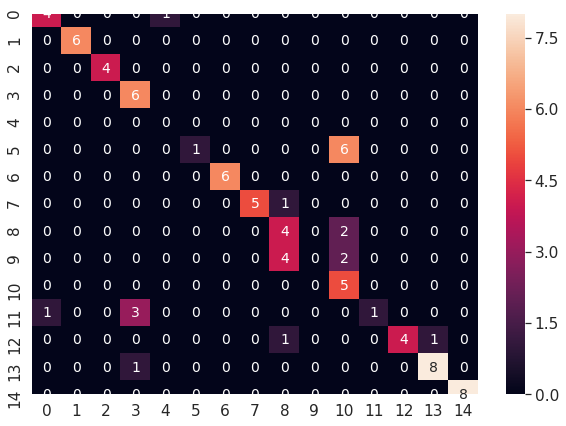

In [98]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(results, range(15),
                  range(15))
plt.figure(figsize = (10,7))
# sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 14})# font size

In [44]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)

In [80]:
# from sklearn.utils.multiclass import unique_labels
# classes = classes[unique_labels(y_test, y_pred)]

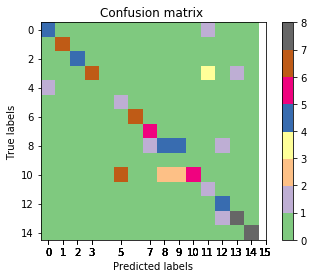

In [77]:
plt.imshow(cm, cmap=plt.cm.Accent)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
# plt.xticks([], [])
plt.xticks(y_pred)
# plt.yticks([], [])
plt.xticks(y_test)
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

# check class image by image

In [ ]:
import glob

test_image_path = r'/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/'

my_name = ['SM_CalgonitFinish_2','SM_CalgonitFinishKlarspueler_5','SM_CalgonitFinishMaschinenpfleger_8','SM_CalgonitFinishSpezialSalz_11',
           'SM_CalgonitFinishVorratspack_14','SM_DenkMitEdelstahlreiniger_17','SM_DenkMitEdelstahlReinigerSpray_20','SM_DenkMitEntkalker_23',
           'SM_DenkMitGeschirrReiniger_26','SM_DenkMitGeschirrReinigerClassic_29','SM_DenkMitGeschirrReinigerEvo_32','SM_DenkMitGeschirrReinigerNature_35',
           'SM_DenkMitHygieneAllzweckreiniger_38','SM_DenkMitMaschinenpfleger_41','SM_DenkMitSpezialsalz_44','SM_SomatClassic_53']

img_path = glob.glob(test_image_path+ '/*.jpg')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),3,IMG_SIZE,IMG_SIZE)
    
    print('image name is: ',image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
#     print('type-of predicted calss: ', type(predicted_class))
    print('class name is: ',my_name[predicted_class[0]])
    
#     probability = model.predict_proba(X_test)
#     print("probability: ",probability)
    print('\n')

# training with data augmentation

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen.fit(X_train)

In [19]:
model_augmentation = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model_augmentation.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [ ]:
nb_epoch = 30
batch_size = 32
model_augmentation.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0],
                            epochs=nb_epoch,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint(path+'model_augmentation_30_epoch_27_aug.h5',save_best_only=True)]
                           )